# Image Outlier Detection with UMAP

In [10]:
import numpy as np
import umap

In [110]:
from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("brad-dwyer").project("aquarium-combined")
dataset = project.version(5).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Aquarium-Combined-5 in coco:: 100%|█████| 646/646 [00:00<00:00, 1242.93it/s]


In [118]:
import torch
import clip
from PIL import Image
import os
import glob

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

[]


In [158]:
all_vectors = {}

files = glob.glob("Aquarium-Combined-5/train/*.jpg") + glob.glob("Aquarium-Combined-5/valid/*.jpg") + glob.glob("Aquarium-Combined-5/test/*.jpg")


for filename in files:
    image = preprocess(Image.open(filename)).unsqueeze(0).to(device)
    # resize image to 416x416
    image = image[:, :, :416, :416]
    with torch.no_grad():
        image_features = model.encode_image(image)
    all_vectors[filename] = image_features.cpu().numpy()

In [7]:
!pip3 install umap-learn umap-learn[plot]

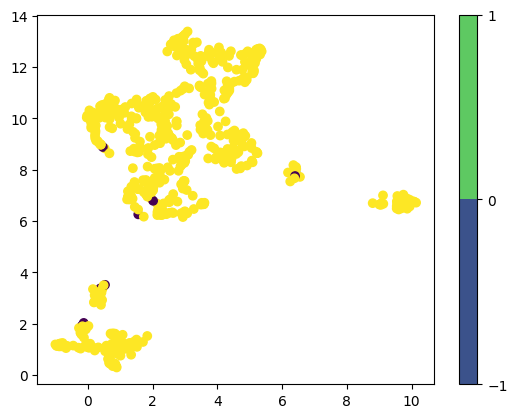

Aquarium-Combined-5/train/IMG_8535_MOV-2_jpg.rf.7801683413ae39eb5a03ae28356175f7.jpg
Aquarium-Combined-5/train/IMG_8598_jpg.rf.f650bd48a6cb6f1580188ae1ef455422.jpg
Aquarium-Combined-5/train/IMG_8535_MOV-3_jpg.rf.74bc4297f8c738e56480f46adadf4038.jpg
Aquarium-Combined-5/train/IMG_8571_MOV-2_jpg.rf.23025cc4b401d7c181ebeb70afda4447.jpg
Aquarium-Combined-5/train/IMG_8494_jpg.rf.179785f2a0e9ad6381d12024d7629a0b.jpg
Aquarium-Combined-5/train/IMG_8531_jpg.rf.5fd3d282ee6ebc6650a4f9e7af27caac.jpg
Aquarium-Combined-5/valid/IMG_2523_jpeg_jpg.rf.8134cf82a6fbf0295a1e43303c62e0c0.jpg
Aquarium-Combined-5/valid/IMG_8535_MOV-5_jpg.rf.0181438c5e280acbabd6371910c208ac.jpg
Aquarium-Combined-5/valid/IMG_8535_MOV-4_jpg.rf.2c7eff1bd3e1104f717cab906902cece.jpg
Aquarium-Combined-5/valid/IMG_8599_MOV-1_jpg.rf.2dff37943d3b3c4197298a951d5b079d.jpg


In [159]:
import umap.umap_ as umap
import umap.plot as plot

# plot using umap as 2d

vectors_list = np.array(list(all_vectors.values())).reshape(-1, 512)

reducer = umap.UMAP(n_components=2)

embedding = reducer.fit(vectors_list)

# plot without labels
# plot.points(embedding)

# plot.points(embedding, labels=np.array(list(vectors.keys())), theme="fire")

# use isolation forest to find outliers

from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=5).fit(vectors_list)

outliers = clf.predict(vectors_list)

# plot outliers

import matplotlib.pyplot as plt

plt.scatter(embedding.embedding_[:, 0], embedding.embedding_[:, 1], c=outliers)
plt.colorbar(boundaries=np.arange(-1, 2, 1))
plt.show()

# show outlier scores

scores = clf.score_samples(vectors_list)

from mpl_toolkits.axes_grid1 import ImageGrid

# print outlier names
for i, outlier in enumerate(outliers):
    if outlier == -1:
        print(list(all_vectors.keys())[i])
# fix overfitting

# show all outliers as grid

Aquarium-Combined-5/train/IMG_8535_MOV-2_jpg.rf.7801683413ae39eb5a03ae28356175f7.jpg
Aquarium-Combined-5/train/IMG_8598_jpg.rf.f650bd48a6cb6f1580188ae1ef455422.jpg
Aquarium-Combined-5/train/IMG_8535_MOV-3_jpg.rf.74bc4297f8c738e56480f46adadf4038.jpg
Aquarium-Combined-5/train/IMG_8571_MOV-2_jpg.rf.23025cc4b401d7c181ebeb70afda4447.jpg
Aquarium-Combined-5/train/IMG_8494_jpg.rf.179785f2a0e9ad6381d12024d7629a0b.jpg
Aquarium-Combined-5/train/IMG_8531_jpg.rf.5fd3d282ee6ebc6650a4f9e7af27caac.jpg
Aquarium-Combined-5/valid/IMG_2523_jpeg_jpg.rf.8134cf82a6fbf0295a1e43303c62e0c0.jpg
Aquarium-Combined-5/valid/IMG_8535_MOV-5_jpg.rf.0181438c5e280acbabd6371910c208ac.jpg
Aquarium-Combined-5/valid/IMG_8535_MOV-4_jpg.rf.2c7eff1bd3e1104f717cab906902cece.jpg
Aquarium-Combined-5/valid/IMG_8599_MOV-1_jpg.rf.2dff37943d3b3c4197298a951d5b079d.jpg


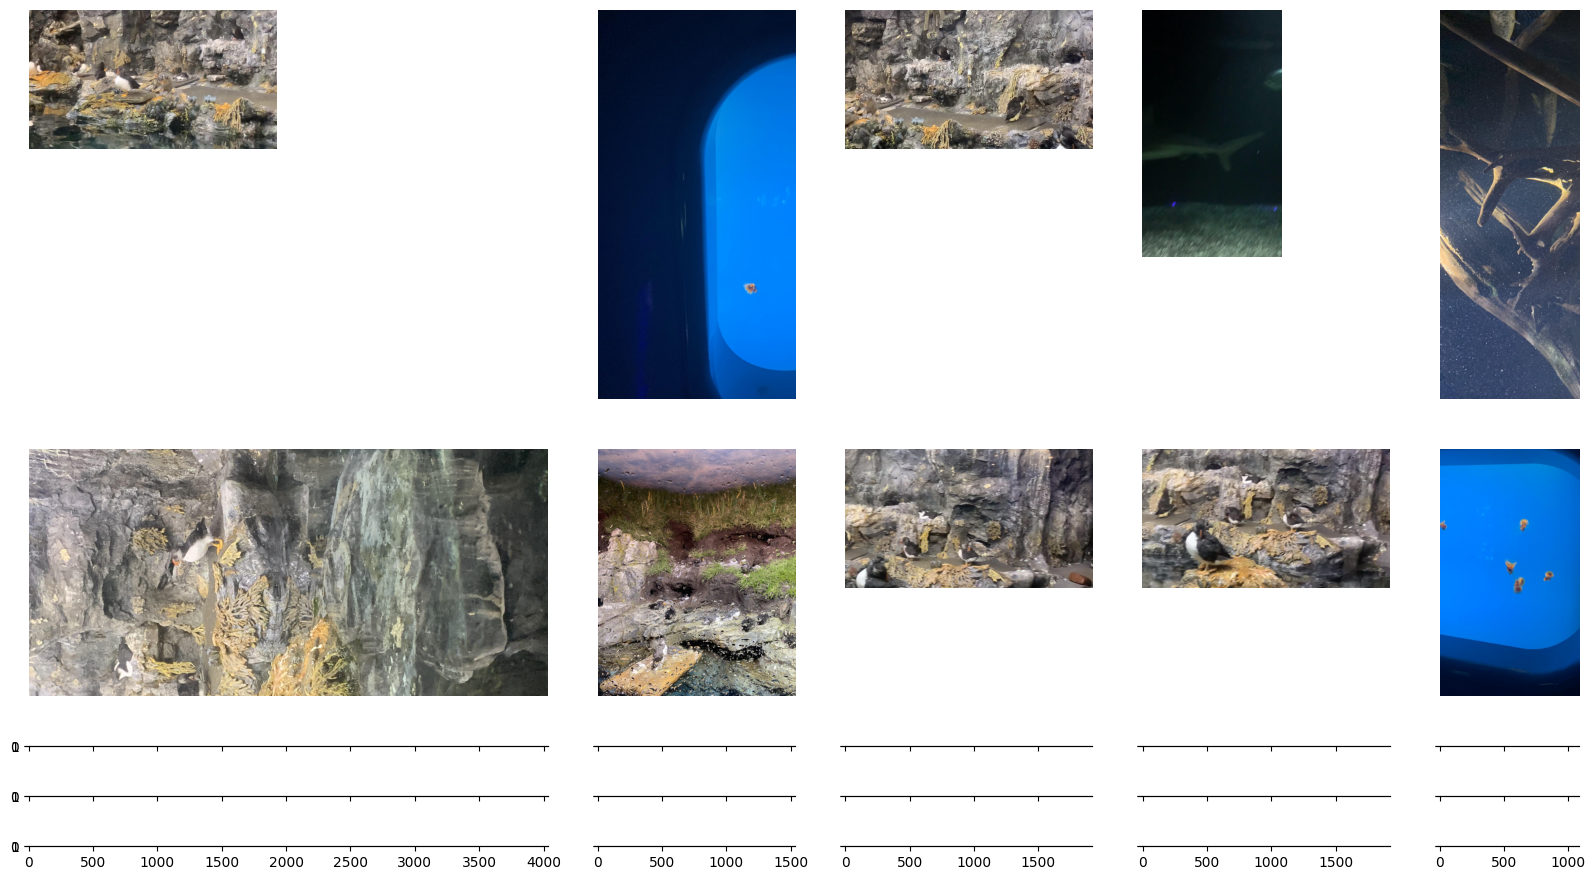

In [160]:
fig = plt.figure(figsize=(20, 20))

grid = ImageGrid(
    fig,
    111,
    nrows_ncols=(5, 5),
    axes_pad=0.5,
)

counter = 0

# show all outliers as grid
for i, outlier in enumerate(outliers):
    if outlier == -1:
        if counter < 25:
            grid[counter].imshow(Image.open(list(all_vectors.keys())[i]))
            # no axis
            grid[counter].axis("off")
            counter += 1
            print(list(all_vectors.keys())[i])

plt.show()

In [166]:
# remove outliers from dataset
import json
base_dir = os.getcwd()

for i, outlier in enumerate(outliers):
    if outlier == -1:
        try:
            os.remove(list(all_vectors.keys())[i])
        except:
            continue

        # coco json

        dir_type = list(all_vectors.keys())[i].split("/")[1]

        with open(f"./Aquarium-Combined-5/{dir_type}/_annotations.coco.json", "r") as f:
            coco_json = json.load(f)

        # remove from coco json

        for j, image in enumerate(coco_json["images"]):
            if image["file_name"] == list(all_vectors.keys())[i].split("/")[2]:
                coco_json["images"].pop(j)
                break
        for j, annotation in enumerate(coco_json["annotations"]):
            if annotation["image_id"] == j:
                coco_json["annotations"].pop(j)
                break
        
        # write coco json
        with open(f"Aquarium-Combined-5/{dir_type}/_annotations.coco.json", "w") as f:
            json.dump(coco_json, f)

# retrain model